# Generate large-scale RTC mosaic

Method:

1. generate STAC ItemCollection (GeoJSON FeatureCollection) from ASF Search Results

This is convenient for loading temporal stacks and mosaics of many images into xarray

Currently hard-coded for OPERA RTC Product
(example: loading all S1 Bursts covering an MGRS square)

In [1]:
# Consider recent scene over UW campus:
import asf_search as asf
import geopandas as gpd
import pandas as pd
import os
import xarray as xr
import numpy as np
import fsspec
import datetime
import ast
import concurrent.futures

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import pystac
from pystac.utils import str_to_datetime

import rasterio

# Import extension version
from rio_stac.stac import PROJECTION_EXT_VERSION, RASTER_EXT_VERSION

# Import rio_stac methods
from rio_stac.stac import (
    get_dataset_geom,
    get_projection_info,
    #get_raster_info,
    #get_eobands_info,
    bbox_to_geom,
    #get_media_type
)

import odc
from odc.geo.geobox import GeoBox
import odc.stac

In [4]:
# Uses ~/.netrc with nasa credentials
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR'
os.environ['GDAL_HTTP_COOKIEJAR']='/tmp/cookies.txt'
os.environ['GDAL_HTTP_COOKIEFILE']='/tmp/cookies.txt'

In [5]:
# https://github.com/developmentseed/rio-stac/blob/4523242b555d1ce2ae4ff7200722579ada1e97c3/docs/docs/examples/Multi_assets_item.ipynb#L9
def asf2stac(row):
    ''' convert geojson from ASF to STAC JSON 
    
    add 'VH','VV','mask' assets. sar extension info, other properties
    
    input: row of geodataframe from asf search results
    output: pystac.Item
    '''
    vh_url = row.url
    vv_url = [x for x in row.additionalUrls if x.endswith('VV.tif')][0]
    meta_url = [x for x in row.additionalUrls if x.endswith('iso.xml')][0]
    mask_url = [x for x in row.additionalUrls if x.endswith('mask.tif')][0]
    
    assets = [ 
        {"name": "vv", "href": vv_url, "role": ['data'], "type":pystac.MediaType.COG},
        {"name": "vh", "href": vh_url, "role": ['data'], "type":pystac.MediaType.COG},
        {"name": "mask", "href": mask_url, "role": ['metadata'], "type":pystac.MediaType.COG},
        {"name": "metadata", "href": meta_url, "role": ['metadata'], "type":pystac.MediaType.XML},
        # Warning: unsure of consistent order...
        {"name": "browse", "href": row.browse[0], "role": ['overview'], "type":pystac.MediaType.PNG},
        {"name": "thumbnail", "href": row.browse[-1], "role": ['thumbnail'], "type":pystac.MediaType.PNG},
    ]

    with rasterio.open(row.url) as src_dst:
        # Get BBOX and Footprint
        dataset_geom = get_dataset_geom(src_dst, densify_pts=0, precision=-1)  
        bbox = dataset_geom["bbox"]

        proj_info = {
            f"proj:{name}": value
            for name, value in get_projection_info(src_dst).items()
        }

    pystac_assets = []

    for asset in assets:
        pystac_assets.append(
            (
                asset["name"], 
                pystac.Asset(
                    href=asset["href"],
                    media_type=asset["type"],
                    #extra_fields={
                        #**proj_info, # Put into properties to avoid duplication
                        #**raster_info, #avoid opening all these for now... 
                    #},
                    roles=asset["role"],
                ),
            )
        )


    #media_type = pystac.MediaType.COG  # we could also use rio_stac.stac.get_media_type

    # additional properties to add in the item
    properties = dict(start_datetime=row.startTime,
                      end_datetime=row.stopTime,
                      processingDate=row.processingDate,
                      operaBurstID=row.operaBurstID,
                      pathNumber=str(row.pathNumber),
                      platform=row.platform,
                      orbit=str(row.orbit),
                     )
    properties['sat:orbit_state']=row.flightDirection.lower()
    properties.update(proj_info)            

    # datetime associated with the item
    input_datetime = str_to_datetime(row.startTime)

    # STAC Item Id
    id = row.sceneName

    # name of collection the item belongs to
    #collection = 'OPERA_L2_RTC'
    #collection_url = None

    extensions =[
        f"https://stac-extensions.github.io/projection/{PROJECTION_EXT_VERSION}/schema.json", 
        #f"https://stac-extensions.github.io/raster/{RASTER_EXT_VERSION}/schema.json",
    ]
    
    # item
    item = pystac.Item(
        id=id,
        geometry=bbox_to_geom(bbox),
        bbox=bbox,
        # collection=collection,
        stac_extensions=extensions,
        datetime=input_datetime,
        properties=properties,
    )

    for key, asset in pystac_assets:
        item.add_asset(key=key, asset=asset)

    #item.validate()
    
    return item

In [6]:
# Mosaic All Washington State!
gfa = gpd.read_file('https://github.com/glynnbird/usstatesgeojson/raw/master/washington.geojson')
gfa.explore()

In [7]:
search_params = dict(
    intersectsWith=gfa.convex_hull.to_wkt()[0],
    dataset='OPERA-S1', # Both CSLC and RTC
    processingLevel='RTC',
    start='2023-11-15',
    end='2023-12-01',
    #flightDirection='DESCENDING',
)

In [8]:
#results = asf_search.geo_search(**search_params) #TypeError: geo_search() got an unexpected keyword argument 'dataset'
results = asf.search(**search_params)
len(results)

413

In [9]:
# ASF Metadata can be represented as geojson, but is not STAC
gf = gpd.GeoDataFrame.from_features(results.geojson(), crs='EPSG:4326')
gf.head(3)

geometry beamModeType  \
0  POLYGON ((-122.78118 48.91436, -122.13817 48.9...           IW   
1  POLYGON ((-121.58517 48.95193, -120.93087 49.0...           IW   
2  POLYGON ((-122.72998 48.74944, -122.08720 48.8...           IW   

                                              browse bytes centerLat  \
0  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   
1  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   
2  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   

  centerLon faradayRotation  \
0      None            None   
1      None            None   
2      None            None   

                                              fileID flightDirection  \
0  OPERA_L2_RTC-S1_T064-135610-IW1_20231128T01550...       ASCENDING   
1  OPERA_L2_RTC-S1_T064-135609-IW2_20231128T01545...       ASCENDING   
2  OPERA_L2_RTC-S1_T064-135609-IW1_20231128T01545...       ASCENDING   

                         groupID  ... sensor             startTime  \
0  S1A_IWDV_0158_0164_051411_064  ...  C-SAR  2023-11-28T01:55:01Z   
1  S1A_IWDV_0158_0164_051411_064  ...  C-SAR  2023-11-28T01:54:59Z   
2  S1A_IWDV_0158_0164_051411_064  ...  C-SAR  2023-11-28T01:54:58Z   

               stopTime                                                url  \
0  2023-11-28T01:55:04Z  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
1  2023-11-28T01:55:02Z  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
2  2023-11-28T01:55:01Z  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   

   pgeVersion                                           fileName frameNumber  \
0       2.1.0  OPERA_L2_RTC-S1_T064-135610-IW1_20231128T01550...        None   
1       2.1.0  OPERA_L2_RTC-S1_T064-135609-IW2_20231128T01545...        None   
2       2.1.0  OPERA_L2_RTC-S1_T064-135609-IW1_20231128T01545...        None   

  beamMode                                     additionalUrls     operaBurstID  
0       IW  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...  T064_135610_IW1  
1       IW  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...  T064_135609_IW2  
2       IW  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...  T064_135609_IW1  

[3 rows x 32 columns]

In [10]:
gf['date'] = pd.to_datetime(gf.startTime).dt.date.astype(str)

In [11]:
cols = ['date','pathNumber','geometry']
#gf[cols].explore(column='date')

In [12]:
# Compare ascending vs descending
# If searching all
gfa = gf[gf.flightDirection == 'ASCENDING']
print('n ascending',len(gfa))
gfd = gf[gf.flightDirection == 'DESCENDING']
print('n descending',len(gfd))

n ascending 231
n descending 182


In [13]:
gfa[cols].explore(column='date')

In [14]:
gfd[cols].explore(column='date')

In [15]:
%%time

# NOTE: expect ~200ms*nrows

args = [job for i,job in gfd.iterrows()]

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    results = executor.map(asf2stac, args)

items = list(results)

CPU times: user 1.55 s, sys: 968 ms, total: 2.52 s
Wall time: 26.2 s


In [16]:
outpath = 'items-wa-202311-dsc.json'
pystac.ItemCollection(items).save_object(outpath)

In [17]:
items = pystac.ItemCollection.from_file(outpath)

In [18]:
ds = odc.stac.load(
    items,
    groupby="solar_day", 
    chunks={'x': 512*8, 'y': 512*8},
    #bands="vv",
    #geobox=GRID
)

ds  

<xarray.Dataset>
Dimensions:      (y: 15633, x: 22846, time: 4)
Coordinates:
  * y            (y) float64 5.484e+06 5.484e+06 ... 5.015e+06 5.015e+06
  * x            (x) float64 3.532e+05 3.532e+05 ... 1.038e+06 1.039e+06
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2023-11-19T14:13:31 ... 2023-11-26T14:...
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 4096, 4096), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 4096, 4096), meta=np.ndarray>
    mask         (time, y, x) float32 dask.array<chunksize=(1, 4096, 4096), meta=np.ndarray>

In [19]:
%%time

ampDVV = ds.vv.coarsen(x=4,y=4,boundary='trim').mean().mean(dim='time')
ampDVV = ampDVV.compute()

/home/jovyan/.local/envs/capella/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 50.5 s, sys: 41 s, total: 1min 31s
Wall time: 1min 13s


In [20]:
# Convert to decibel scale
ampDVV = 10*np.log10(ampDVV)

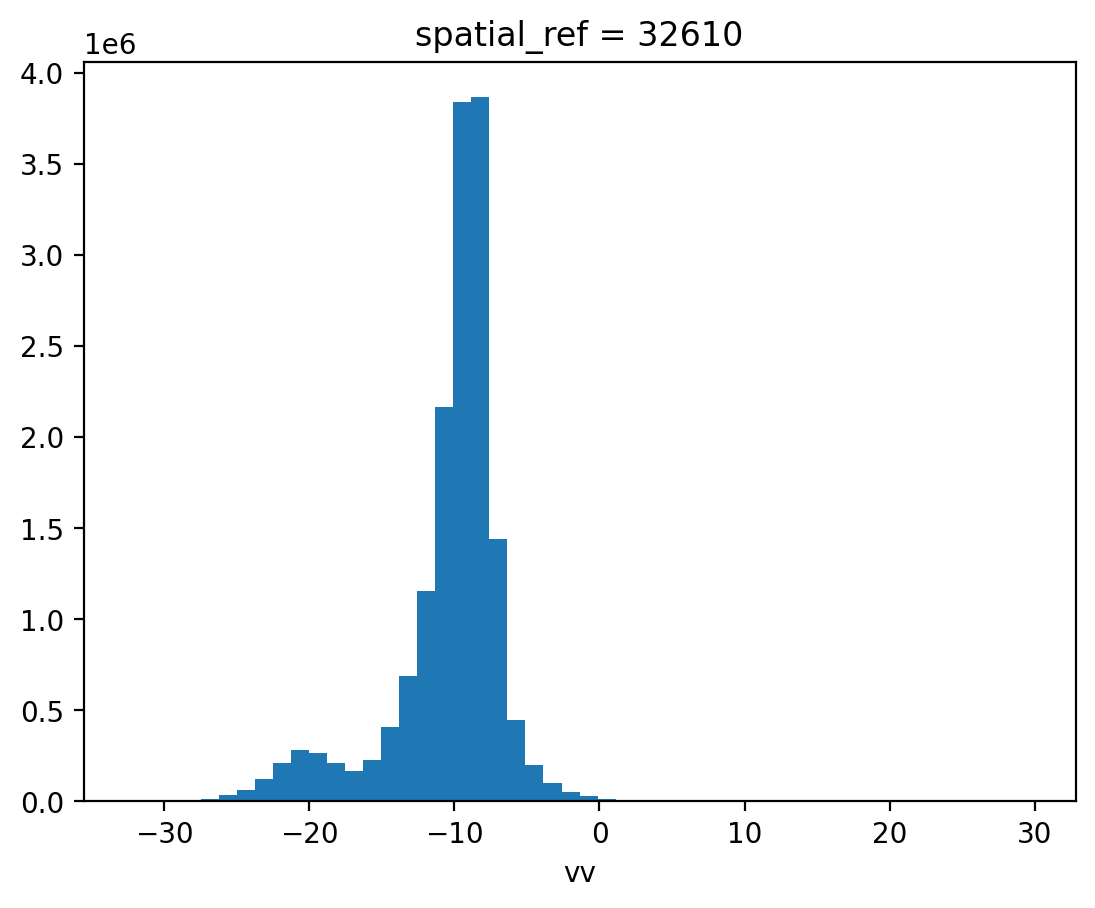

In [21]:
ampDVV.plot.hist(bins=50);

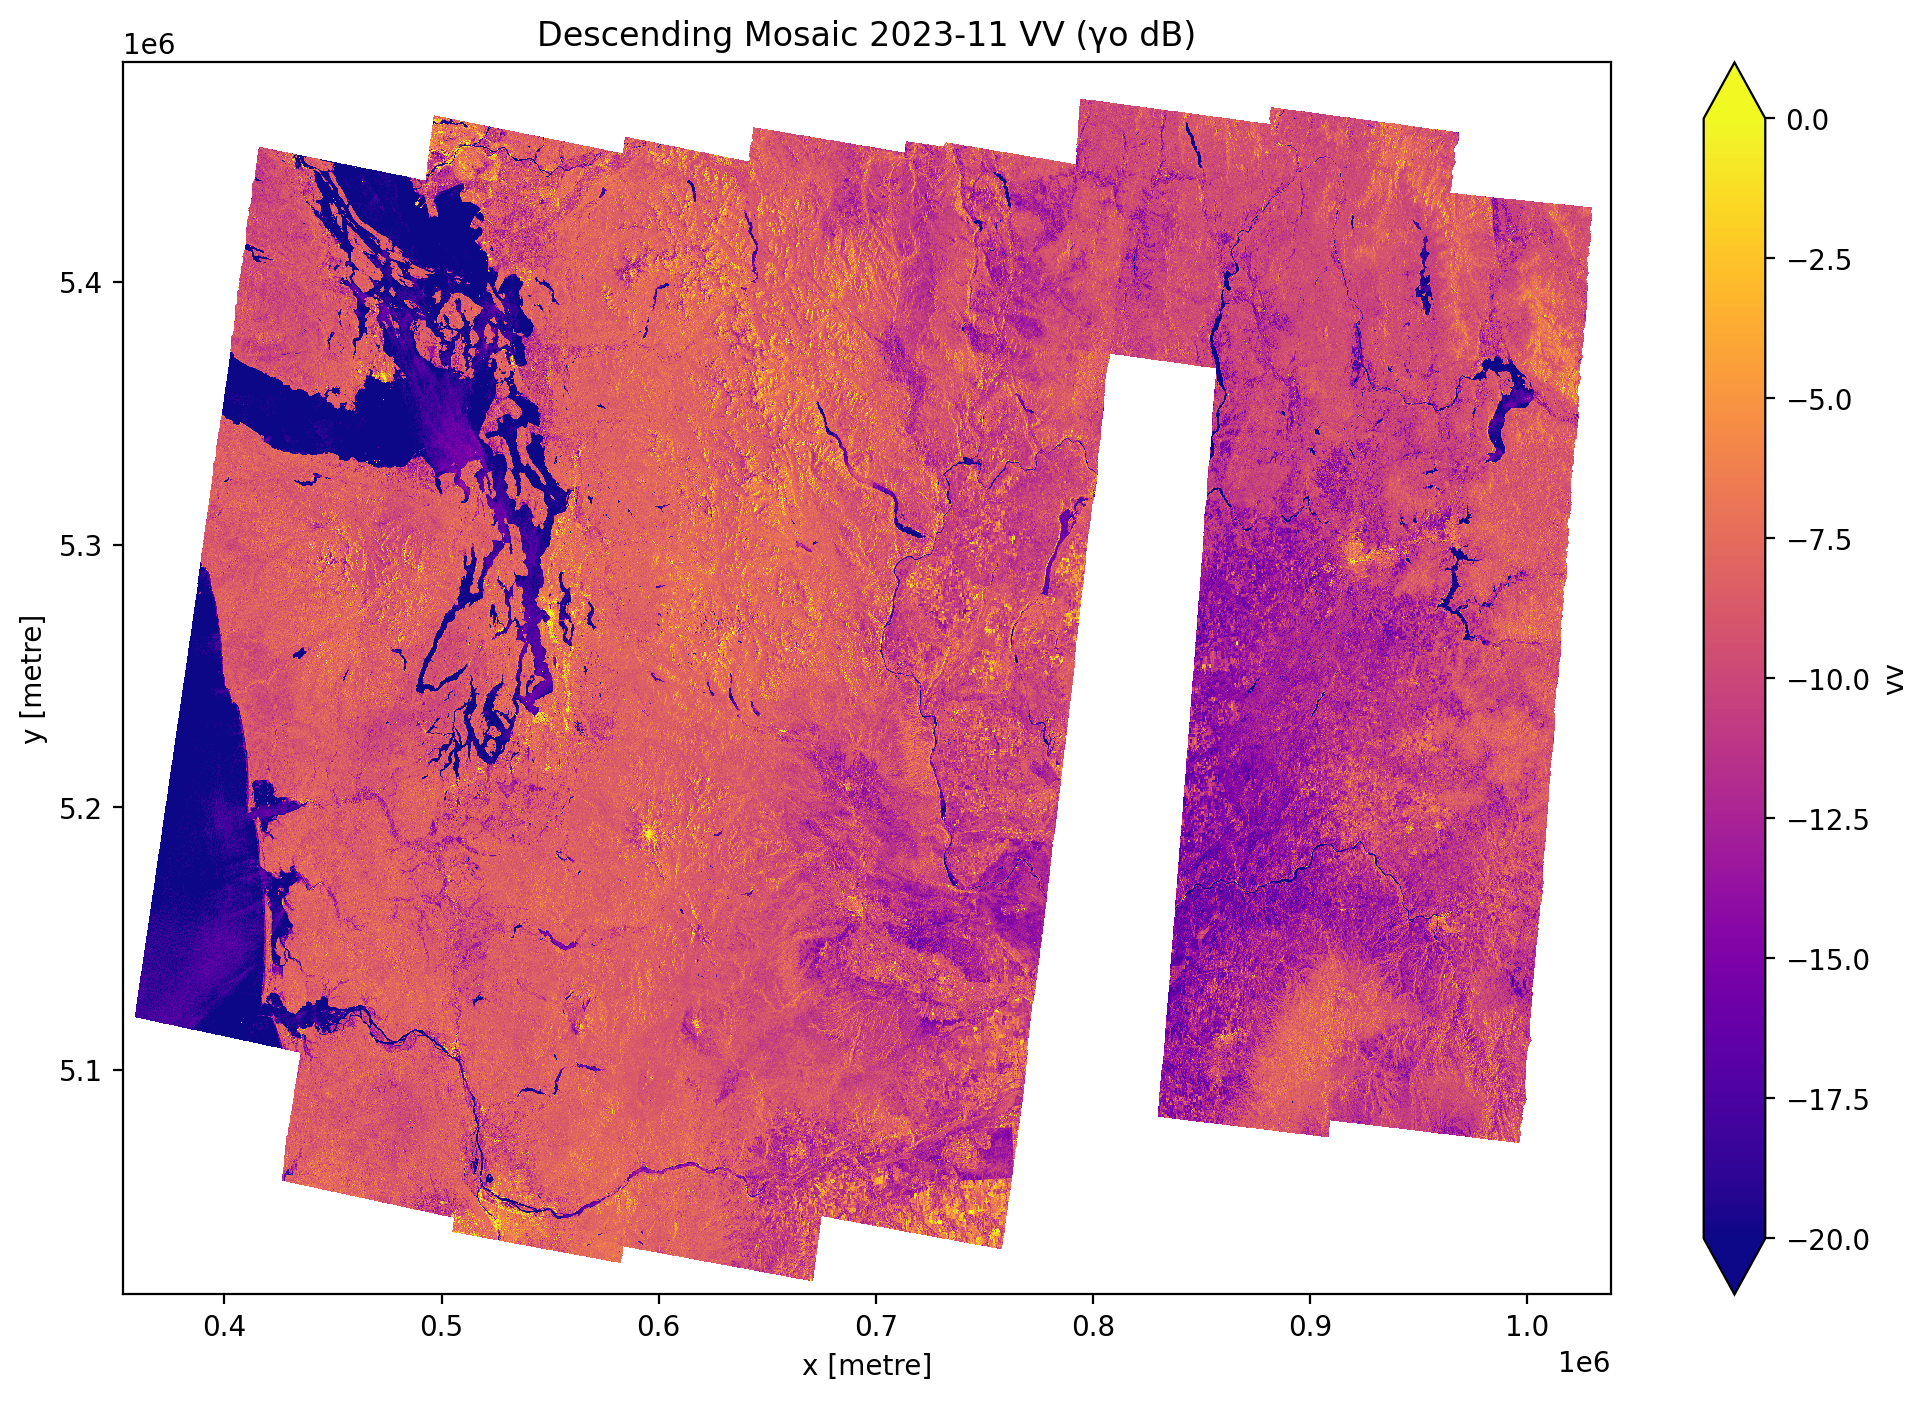

In [22]:
fig,ax = plt.subplots(figsize=(12,8), subplot_kw=dict(aspect='equal'))
ampDVV.plot.imshow(vmin=-20, vmax=0, cmap='plasma',ax=ax);
plt.title('Descending Mosaic 2023-11 VV (γo dB)');